# Fitting Anisotropic Power Diagrams to Grain Maps

In [1]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt

from torchmin import minimize as minimize_torch

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### To check that the approach works, we will first create a small artificial 2D grain map using `PyAPD`:

Precision loss detected!
Percentage error =  95.62935638427734
Lloyds iteration: 0
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 5
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 6
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 7
Optimality condition successfully o

(<Figure size 756x756 with 1 Axes>, <Axes: >)

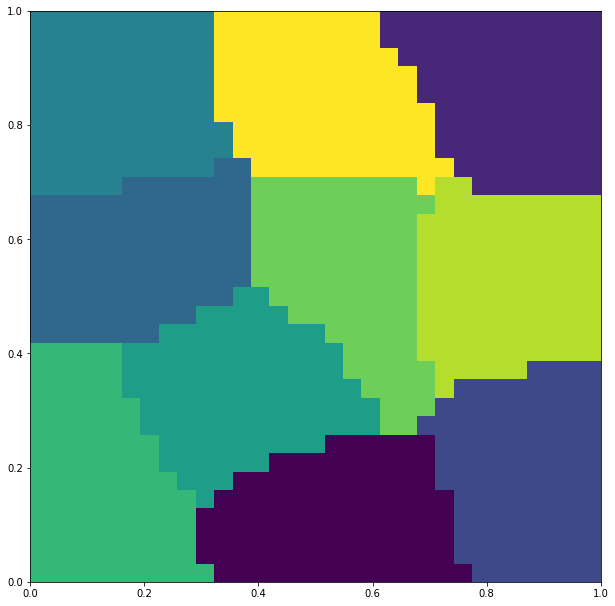

In [2]:
N = 10 # number of grains
apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = 1.0
)
apd1.check_optimality()
#apd1.find_optimal_W()
apd1.Lloyds_algorithm(K=10)
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

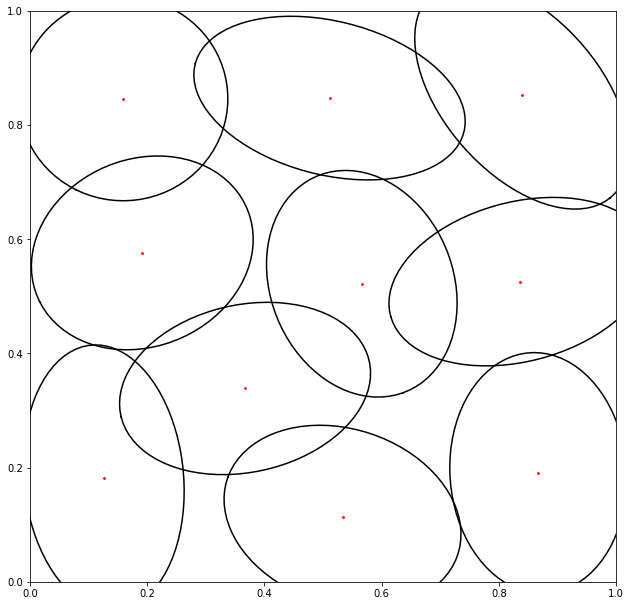

In [3]:
apd1.plot_ellipses()

In [4]:
# Save the data:
W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

# Save the grain map:
Y = copy.deepcopy(apd1.Y)
II = copy.deepcopy(apd1.assemble_apd())
II = II + 1
y = LazyTensor(Y.view(1, len(Y), 2))
print("We have ", len(Y), " pixels and ", N, " grains.")

We have  961  pixels and  10  grains.


## Reduced approach: fitting $W$

#### Equipped with the grain map, as a warm up let us try to use the approach to recover $W$. For this we do not need to rescale the variables, so we just proceed as follows:

In [5]:
eps = 1e-3 # regularisation parameter
gtol_scalar = 1e-4

In [6]:
def objective_function(X,A,W):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()

    a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
    w = LazyTensor(W.view(dims[0],1,1))
    x = LazyTensor(X.view(dims[0], 1, dims[1]))
    D_ij = ((y - x) | a.matvecmult(y - x)) - w
    second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    return -eps*(first_sum - second_sum)

# Defining the convex function to be optmised:
fun_red = lambda W : objective_function(X_true,As_true, W)

In [7]:
gtol = gtol_scalar*torch.ones(N).to(device=device) # optimality condition (can be passed as vector!)

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':100,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

#solver = 'cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun_red, torch.zeros(N), method=solver, disp= 3,
                             options=defaultKwargs)

W_approx = res.x

Optimality condition successfully overwritten.
initial fval: 0.2244
iter   1 - fval: 0.0652
iter   2 - fval: 0.0223
iter   3 - fval: 0.0135
iter   4 - fval: 0.0117
iter   5 - fval: 0.0108
iter   6 - fval: 0.0107
iter   7 - fval: 0.0106
iter   8 - fval: 0.0105
iter   9 - fval: 0.0105
iter  10 - fval: 0.0105
iter  11 - fval: 0.0105
iter  12 - fval: 0.0105
iter  13 - fval: 0.0105
iter  14 - fval: 0.0105
iter  15 - fval: 0.0105
iter  16 - fval: 0.0105
iter  17 - fval: 0.0105
iter  18 - fval: 0.0105
Optimization terminated successfully.
         Current function value: 0.010531
         Iterations: 18
         Function evaluations: 20


In [8]:
res.grad

tensor([ 0.0000e+00,  3.0518e-05,  0.0000e+00,  7.6294e-06, -7.6294e-06,
        -7.6294e-06, -7.6294e-06, -7.6294e-06,  0.0000e+00, -2.2888e-05])

In [9]:
print(fun_red(W_approx))
print(fun_red(W_true))

tensor([0.0105])
tensor([0.0127])


Number of misassigned pixels:  tensor(2)
Proportion of misassigned pixels:  tensor(0.0021)


Text(0.5, 1.0, 'Misalligned pixels')

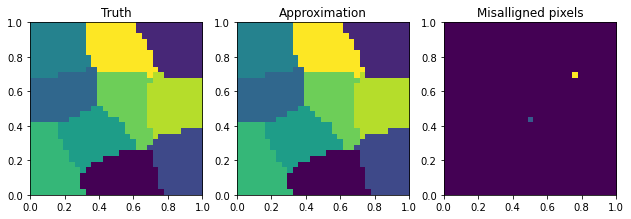

In [10]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

apd1.set_W(W = W_true) # reset weights to the optimum

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### All seems to work pretty well!

## Full approach: Fitting $X$, $\Lambda$ and $W$ at the same time

#### First let us try a naive approach where we do not worry too much about the matrices $\mathbf{A}_i$ being positive definite, but only with them being symmetric. That way each matrix only gives three variables $a_{i,11}$, $a_{i,22}$ and $a_{i,12}$. We thus have a flat variable
$$
\theta = \{(x_{i,1}, x_{i,2}, a_{i,11}, a_{i,22}, a_{i,12}, w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$
#### and e.g. we can assemble the optimum that we know:

In [11]:
theta_true = torch.cat((X_true[:,0],X_true[:,1],As_true[:,0,0],As_true[:,1,1],As_true[:,0,1],W_true))
theta_true.shape

torch.Size([60])

#### We can also introduce the rescaled variables 
$$
\tilde \theta = \{(\tilde x_{i,1}, \tilde x_{i,2}, \tilde a_{i,11}, \tilde a_{i,22}, \tilde a_{i,12}, \tilde w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$

In [12]:
def rescaling(X, As, W):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

In [13]:
Xt_true, At_true, Wt_true = rescaling(X_true, As_true, W_true)
thetat_true = torch.cat((Xt_true[:,0],Xt_true[:,1],At_true[:,0,0],At_true[:,1,1],At_true[:,0,1],Wt_true))

#### And the new rescaled objective is

In [14]:
def objective_function_tilde(Xt,At,Wt):
    dims = At.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,II-1), Y)
    sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, II-1) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, II-1),Y)
    first_sum = (-sD_ij).sum()

    at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
    wt = LazyTensor(Wt.view(dims[0],1,1))
    xt = LazyTensor(Xt.view(dims[0], 1, dims[1]))
    D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
    second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
    
    return -(first_sum - second_sum)

#### We also want have the ability to go from flat variables to shaped variables quickly, so here are some helper functions:

In [15]:
def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [16]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W(thetat_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W(theta_true)
print(torch.dist(As_test,As_true))

tensor(9.8962e-08)
tensor(9.6642e-08)


In [17]:
# Defining the convex function to be optmised:
def fun(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [18]:
# Sanity check
print(eps*fun(thetat_true),fun_red(W_true))

tensor([0.0127]) tensor([0.0127])


In [19]:
(gtol_scalar/eps)

0.1

In [20]:
gtol = (gtol_scalar/eps)*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

#thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
#                            ((eps)**(-1.0))*torch.ones(N),((eps)**(-1.0))*torch.ones(N), torch.zeros(N),
#                            torch.zeros(N)))

thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            torch.ones(N),torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun(thetat_initial)

tensor([446403.1875])

In [22]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0.0, 'disp': 2, 'max_iter':10000}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':200,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun, thetat_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 446403.1875
iter   1 - fval: 257806.0625
iter   2 - fval: 243777.0000
iter   3 - fval: 176859.0625
iter   4 - fval: 159940.2500
iter   5 - fval: 157975.9375
iter   6 - fval: 140299.2500
iter   7 - fval: 113611.3750
iter   8 - fval: 102190.3125
iter   9 - fval: 77891.6875
iter  10 - fval: 59833.5625
iter  11 - fval: 58334.0000
iter  12 - fval: 42209.6250
iter  13 - fval: 36578.4375
iter  14 - fval: 25716.8750
iter  15 - fval: 22435.8750
iter  16 - fval: 17125.9375
iter  17 - fval: 13780.6875
iter  18 - fval: 10565.9375
iter  19 - fval: 5420.0625
iter  20 - fval: 3711.4375
iter  21 - fval: 3300.0000
iter  22 - fval: 2908.5000
iter  23 - fval: 2570.2500
iter  24 - fval: 2311.5000
iter  25 - fval: 1882.6875
iter  26 - fval: 1527.2500
iter  27 - fval: 1063.0000
iter  28 - fval: 788.1250
iter  29 - fval: 685.0625
iter  30 - fval: 590.5625
iter  31 - fval: 560.8125
iter  32 - fval: 515.0000
iter  33 - fval: 478.0625
iter  34 - fval:

In [23]:
res.grad

tensor([-0.0371,  0.0557, -0.0060, -0.0195,  0.0488,  0.0033,  0.0188, -0.0461,
         0.0158, -0.0338,  0.0114,  0.0780, -0.0556,  0.0273, -0.0162, -0.0227,
        -0.0269,  0.0493,  0.0312, -0.0758,  0.0245, -0.0570, -0.0531,  0.0224,
        -0.0312, -0.0111, -0.0123, -0.0282,  0.0525,  0.0936, -0.0128, -0.0474,
         0.0275, -0.0435,  0.0982,  0.0205,  0.0053,  0.0275, -0.0802,  0.0050,
        -0.0092, -0.1323,  0.0305,  0.0042, -0.0462,  0.0656,  0.0110, -0.0206,
        -0.0464,  0.1434,  0.0023,  0.0748, -0.0601, -0.0122,  0.0660, -0.0127,
        -0.0091, -0.0273,  0.0453, -0.0669])

In [24]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [25]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(),
                        As = As_approx.contiguous(),
                        W = W_approx2.contiguous(),
                        pixel_size_prefactor = 1.0,
                       )

Number of misassigned pixels:  tensor(25)
Proportion of misassigned pixels:  tensor(0.0260)


Text(0.5, 1.0, 'Misalligned pixels')

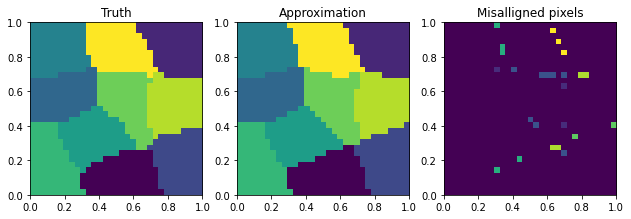

In [26]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

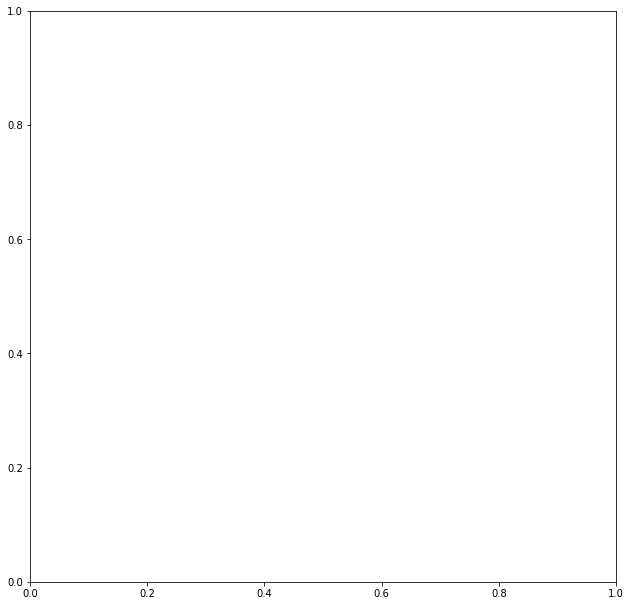

In [27]:
apd2.plot_ellipses()

In [28]:
torch.linalg.det(apd2.As)

tensor([-0.1975, -0.0850, -0.0544, -0.0190, -0.0354, -0.0724, -0.0278, -0.0195,
        -0.0183, -0.2166])

#### Not caring about positive definiteness of the matrices seems to affect things, which can be seen e.g. by restarting the optimisation procedure at a better initial guess:

In [29]:
print("The found optimum: ", fun(res.x))
print("The known actual optimum: ", fun(thetat_true))

The found optimum:  tensor([72.7500])
The known actual optimum:  tensor([12.6738])


In [30]:
res2 = PyAPD.minimize_torch(fun, thetat_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 12.6738
iter   1 - fval: 12.1660
iter   2 - fval: 10.8887
iter   3 - fval: 10.2910
iter   4 - fval: 9.8828
iter   5 - fval: 9.6211
iter   6 - fval: 9.3789
iter   7 - fval: 9.1719
iter   8 - fval: 8.9648
iter   9 - fval: 8.6816
iter  10 - fval: 8.3613
iter  11 - fval: 8.1113
iter  12 - fval: 7.9688
iter  13 - fval: 7.8594
iter  14 - fval: 7.7715
iter  15 - fval: 7.6914
iter  16 - fval: 7.6445
iter  17 - fval: 7.6230
iter  18 - fval: 7.5859
iter  19 - fval: 7.5391
iter  20 - fval: 7.4980
iter  21 - fval: 7.4551
iter  22 - fval: 7.4199
iter  23 - fval: 7.3711
iter  24 - fval: 7.3301
iter  25 - fval: 7.2910
iter  26 - fval: 7.2734
Optimization terminated successfully.
         Current function value: 7.273438
         Iterations: 26
         Function evaluations: 27


In [31]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res2.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [32]:
torch.linalg.det(As_approx)

tensor([0.9999, 0.9985, 0.9992, 1.0022, 1.0012, 0.9995, 1.0003, 1.0000, 0.9968,
        1.0007])

In [33]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(),
                        As = As_approx.contiguous(),
                        W = W_approx2.contiguous(),
                        pixel_size_prefactor=1,
                       )

Number of misassigned pixels:  tensor(0)
Proportion of misassigned pixels:  tensor(0.)


Text(0.5, 1.0, 'Misalligned pixels')

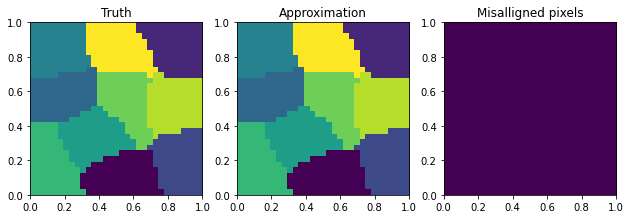

In [34]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### Another issues worth thinking about is the interplay and redundancies with respect to $X$, $\Lambda$ and $W$, e.g. the determinant of matrices, the shifting of weights by a constant etc.

## Less naive approach

In [41]:
def As_from_cholesky(l11,l22,l12):
    L = torch.stack([torch.stack([torch.exp(l11), l12],dim=1),
                            torch.stack([torch.zeros(len(l11)), torch.exp(l22)], dim=1)],dim=2)
    return L @ torch.transpose(L,1,2)

In [42]:
def from_theta_to_X_A_W_cholesky(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    l22 = theta[(3*N):(4*N)]
    l12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [49]:
Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_true = torch.cat((X_true[:,0],X_true[:,1],torch.log(Ls_true[:,0,0]),torch.log(Ls_true[:,1,1]),Ls_true[:,1,0],W_true))
theta_cholesky_true.shape

torch.Size([60])

In [53]:
Lt_true = Ls_true/(eps**(0.5))

thetat_cholesky_true = torch.cat((Xt_true[:,0],
                                  Xt_true[:,1],
                                  torch.log(Lt_true[:,0,0]),
                                  torch.log(Lt_true[:,1,1]),
                                  Lt_true[:,1,0],Wt_true)
                                )
thetat_cholesky_true.shape

torch.Size([60])

In [56]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky(thetat_cholesky_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky(theta_cholesky_true)
print(torch.dist(As_test,As_true))

tensor(1.0642e-06)
tensor(3.5075e-07)


In [57]:
# Defining the convex function to be optmised:
def fun_cholesky(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [58]:
# Sanity check
print(eps*fun(thetat_true), eps*fun_cholesky(thetat_cholesky_true),fun_red(W_true))

tensor([0.0127]) tensor([0.0127]) tensor([0.0127])


In [59]:
gtol = (gtol_scalar)*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.25))*torch.ones(N),((eps)**(-0.25))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky(thetat_cholesky_initial)

tensor([654648.])

In [60]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':500,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_initial, method=solver,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 654648.0000
iter   1 - fval: 543632.0000
iter   2 - fval: 420468.0000
iter   3 - fval: 340064.0000
iter   4 - fval: 255956.0000
iter   5 - fval: 194204.0000
iter   6 - fval: 164592.0000
iter   7 - fval: 128996.0000
iter   8 - fval: 127972.0000
iter   9 - fval: 118900.0000
iter  10 - fval: 116468.0000
iter  11 - fval: 114736.0000
iter  12 - fval: 110152.0000
iter  13 - fval: 107764.0000
iter  14 - fval: 105432.0000
iter  15 - fval: 102692.0000
iter  16 - fval: 100608.0000
iter  17 - fval: 98488.0000
iter  18 - fval: 97688.0000
iter  19 - fval: 96472.0000
iter  20 - fval: 94984.0000
iter  21 - fval: 93784.0000
iter  22 - fval: 92400.0000
iter  23 - fval: 90128.0000
iter  24 - fval: 89564.0000
iter  25 - fval: 89160.0000
iter  26 - fval: 87884.0000
iter  27 - fval: 87712.0000
iter  28 - fval: 87532.0000
iter  29 - fval: 86848.0000
iter  30 - fval: 86448.0000
iter  31 - fval: 86008.0000
iter  32 - fval: 85704.0000
iter  33 - fval

In [61]:
res.grad

tensor([-1.5970e+00,  5.6327e+01, -1.9819e+00, -8.9090e-01, -2.8066e-01,
        -1.9461e+01, -8.0409e+00, -1.6377e+01, -2.8406e+00, -4.8574e+00,
         1.4860e+00,  5.3174e+01, -1.7331e+00,  1.4518e+00,  1.7234e+00,
        -1.9619e+01, -1.1234e+01, -1.5569e+01, -2.6309e+00, -7.0486e+00,
        -1.5841e+05, -8.9172e+04,  1.3239e+05,  4.8130e+04,  4.0343e+04,
         8.4251e+04,  1.3008e+04,  7.3354e+04, -8.8513e+04, -5.5003e+04,
        -1.2468e+05, -8.7684e+04,  6.4728e+04,  8.4556e+04, -6.9103e+03,
        -1.3240e+04, -7.2457e+04,  1.0764e+05, -3.0508e+04,  7.6476e+04,
        -9.1936e+02,  1.0669e+03,  5.6172e+02,  1.6225e+02,  2.9791e+02,
        -6.4973e+01, -6.8586e+02, -3.0194e+02, -2.0035e+02,  8.9595e+01,
        -1.0749e+01,  2.2868e+02, -3.4417e+00,  1.5383e+01,  4.3186e+00,
        -7.3613e+01, -8.7597e+01, -4.9320e+01, -7.7975e+00, -1.5863e+01])

In [62]:
Xt_approx3, At_approx3, Wt_approx3 = from_theta_to_X_A_W_cholesky(res.x)
X_approx3, As_approx3, W_approx3 = inverse_rescaling(Xt_approx3, At_approx3, Wt_approx3)

In [63]:
torch.linalg.det(As_approx3)

tensor([5953.4668, 5948.6299, 5862.7144, 5922.4272, 6033.0200, 5838.8501,
        5742.0264, 5897.8027, 5815.2822, 5723.9355])

In [64]:
apd3 = PyAPD.apd_system(X = X_approx3.contiguous(),
                        As = As_approx3.contiguous(),
                        W = W_approx3.contiguous(),
                       pixel_size_prefactor=1)

Number of misassigned pixels:  tensor(519)
Proportion of misassigned pixels:  tensor(0.5401)


Text(0.5, 1.0, 'Misalligned pixels')

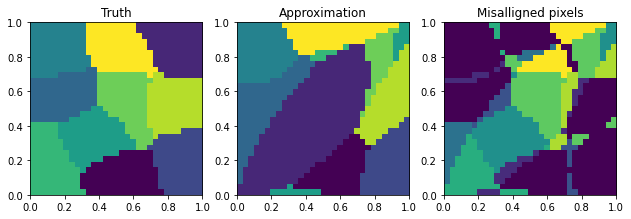

In [65]:
img_approx3 = copy.deepcopy(apd3.assemble_apd())

difff = sum(torch.abs(img_true - img_approx3) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx3.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx3).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

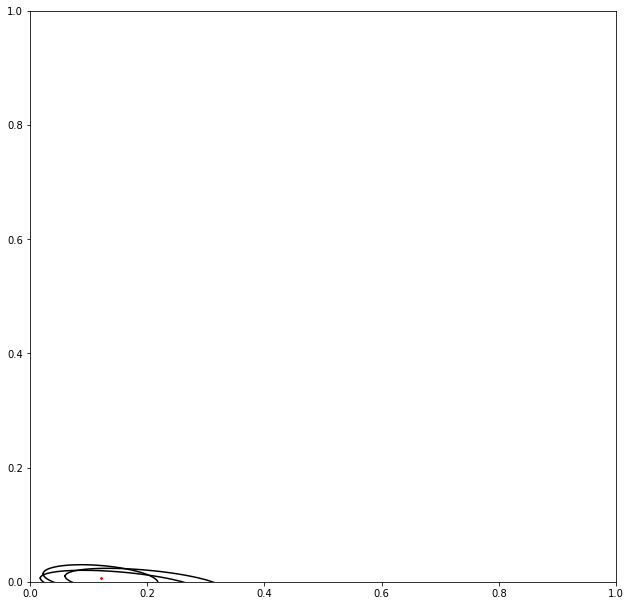

In [98]:
apd3.plot_ellipses()

In [99]:
res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
Maximum number of iterations has been exceeded.
         Current function value: 0.765625
         Iterations: 200
         Function evaluations: 1325


## Keeping determinant fixed

In [113]:
def from_theta_to_X_A_W_cholesky_red(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    #l22 = theta[(3*N):(4*N)]
    l22 = 1.0/(eps*l11)
    l12 = theta[(3*N):(4*N)]
    Wt = theta[(4*N):(5*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [114]:
#Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_red_true = torch.cat((X_true[:,0],X_true[:,1],Ls_true[:,0,0],Ls_true[:,1,0],W_true))
theta_cholesky_red_true.shape

torch.Size([50])

In [115]:
thetat_cholesky_red_true = torch.cat((Xt_true[:,0],Xt_true[:,1],Lt_true[:,0,0],Lt_true[:,1,0],Wt_true))
thetat_cholesky_red_true.shape

torch.Size([50])

In [116]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky_red(theta_cholesky_red_true)
print(torch.dist(As_test,As_true)) # that's fine for now

tensor(5.6083e-07, grad_fn=<MulBackward0>)
tensor(3.5169e+08, grad_fn=<DistBackward0>)


In [117]:
# Defining the convex function to be optmised:
def fun_cholesky_red(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky_red(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [118]:
# Sanity check
print(fun(thetat_true), fun_cholesky(thetat_cholesky_true),fun_cholesky_red(thetat_cholesky_red_true))

tensor([2.0469], grad_fn=<NegBackward0>) tensor([2.0156], grad_fn=<NegBackward0>) tensor([2.0469], grad_fn=<NegBackward0>)


In [119]:
gtol = (gtol_scalar/eps)*torch.ones(5*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_red_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.5))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky_red(thetat_cholesky_red_initial)

tensor([7148005.])

In [120]:
_, At_initial_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_initial)
torch.linalg.det(At_initial_test)

tensor([100000000., 100000000., 100000000., 100000000., 100000000., 100000000.,
        100000000., 100000000., 100000000., 100000000.])

In [121]:
At_initial_test[0]

tensor([[10000.,     0.],
        [    0., 10000.]])

In [122]:
solver = 'bfgs'
defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 7148005.0000
iter   1 - fval: 4306730.0000
iter   2 - fval: 2759235.0000
iter   3 - fval: 2463237.0000
iter   4 - fval: 2148193.0000
iter   5 - fval: 1982283.7500
iter   6 - fval: 1897836.5000
iter   7 - fval: 1678190.5000
iter   8 - fval: 1542174.5000
iter   9 - fval: 1498632.5000
iter  10 - fval: 1343186.7500
iter  11 - fval: 1291043.3750
iter  12 - fval: 1250752.5000
iter  13 - fval: 1207443.1250
iter  14 - fval: 1131895.5000
iter  15 - fval: 1099226.7500
iter  16 - fval: 1088704.5000
iter  17 - fval: 1073937.2500
iter  18 - fval: 1050335.7500
iter  19 - fval: 1030784.7500
iter  20 - fval: 976594.2500
iter  21 - fval: 936660.1250
iter  22 - fval: 903304.2500
iter  23 - fval: 839290.8750
iter  24 - fval: 776284.1250
iter  25 - fval: 750423.5000
iter  26 - fval: 717858.5000
iter  27 - fval: 701420.5000
iter  28 - fval: 690720.2500
iter  29 - fval: 668004.2500
iter  30 - fval: 653980.5000
iter  31 - fval: 618097.2500
iter  32

In [123]:
Xt_approx4, At_approx4, Wt_approx4 = from_theta_to_X_A_W_cholesky_red(res.x)
X_approx4, As_approx4, W_approx4 = inverse_rescaling(Xt_approx4, At_approx4, Wt_approx4)

In [124]:
torch.linalg.det(As_approx4)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [127]:
apd4 = PyAPD.apd_system(X = X_approx4.contiguous(),
                        As = As_approx4.contiguous(),
                        W = W_approx4.contiguous(),
                        pixel_size_prefactor=1,
                       )

Number of misassigned pixels:  tensor(491)
Proportion of misassigned pixels:  tensor(0.5109)


Text(0.5, 1.0, 'Misalligned pixels')

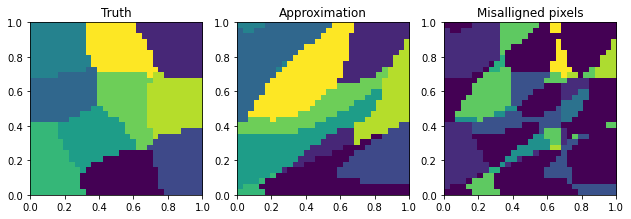

In [128]:
img_approx4 = copy.deepcopy(apd4.assemble_apd())

difff = sum(torch.abs(img_true - img_approx4) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx4.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx4).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

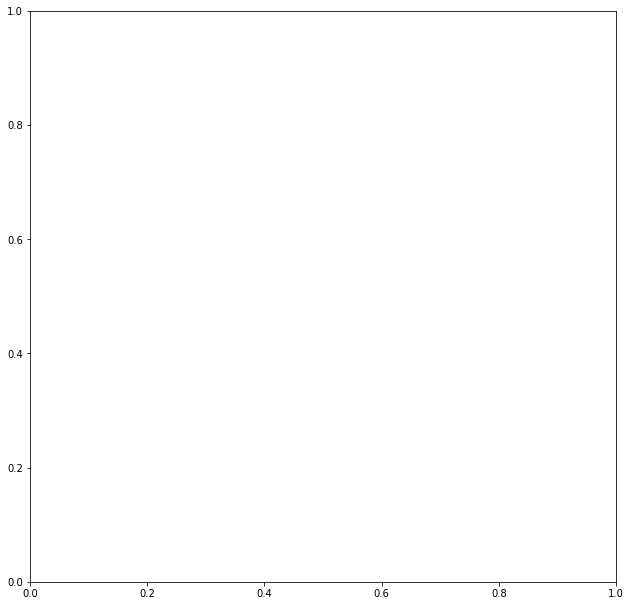

In [129]:
apd4.plot_ellipses()

In [57]:
res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 41.0078
iter   1 - fval: 40.1641
iter   2 - fval: 39.5156
iter   3 - fval: 39.3203
iter   4 - fval: 38.9219
iter   5 - fval: 38.8359
iter   6 - fval: 38.7891
iter   7 - fval: 38.7344
iter   8 - fval: 38.6797
iter   9 - fval: 38.6094
iter  10 - fval: 38.5234
iter  11 - fval: 38.4453
iter  12 - fval: 38.3672
iter  13 - fval: 38.2969
iter  14 - fval: 38.1953
iter  15 - fval: 38.0625
iter  16 - fval: 37.9297
iter  17 - fval: 37.8672
iter  18 - fval: 37.8438
iter  19 - fval: 37.8281
iter  20 - fval: 37.8125
iter  21 - fval: 37.7969
iter  22 - fval: 37.7734
iter  23 - fval: 37.7656
iter  24 - fval: 37.7500
iter  25 - fval: 37.7500
Optimization terminated successfully.
         Current function value: 37.750000
         Iterations: 25
         Function evaluations: 27


In [102]:
import numpy as np

In [104]:
np.exp(-1/eps)

0.0